## Text Summarization using RNN

AUTHOR: Lok Yee Joey Cheung

This file is used to build RNN summarization model from scratch.

#### Install dependencies

In [ ]:
!pip install keras-preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.models import load_model
from sklearn.model_selection import train_test_split
import re

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load Dataset

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/data7901,7903/data/samsum-train.csv')
test = pd.read_csv('/content/drive/MyDrive/data7901,7903/data/samsum-test.csv')
val = pd.read_csv('/content/drive/MyDrive/data7901,7903/data/samsum-validation.csv')

In [ ]:
pd.set_option('display.max_colwidth', 1000)

seed = 42

In [ ]:
# Define a function to generate candidate summary
def summary(txt):
    input = input_tok.texts_to_sequences([txt])
    input = pad_sequences(input, maxlen=max_input_len, padding='post')
    target = np.zeros((1, max_target_len), dtype='int') # initialize target array to be predicted
    target[0,0] = target_tok.word_index.get('<sos>', 0)
    summary = ''

    stop = False
    while not stop:
        # Predict the next word
        outputs = model.predict([input, target])
        # Extracts the predicted index of the word with the highest probability
        pred_idx = np.argmax(outputs[0, 0, :])
        pred_word = None
        # Iterates through the target tokenizer’s word index to find the word corresponding to the predicted index
        for word, idx in target_tok.word_index.items():
            if idx == pred_idx:
                summary += ' {}'.format(word)
                pred_word = word

        if pred_word == '<eos>' or len(summary.split()) > max_target_len:
            stop = True
        # Use the predicted index as the next input in the target sequence
        target[0, 0] = pred_idx

    return summary


#### Data Preprocessing

In [ ]:
# Define a function to clean the dataframe
def clean_df(df, cols):
    for col in cols:
        df[col] = df[col].fillna('').apply(lambda text: re.sub('<.*?>', '', text))  # Remove tags
        df[col] = df[col].apply(lambda text: '\n'.join([line for line in text.split('\n') if not re.match('.*:\s*$', line)]))  # Remove empty dialogues
    return df

# Cleaning texts in all datasets
train= clean_df(train,['dialogue', 'summary'])
test = clean_df(test,['dialogue', 'summary'])
val = clean_df(val,['dialogue', 'summary'])

In [ ]:
# Define a function to perform tokenization 
def tokenize(train,val):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(train)
  tr_seq = tokenizer.texts_to_sequences(train)
  val_seq = tokenizer.texts_to_sequences(val)
  max_len = max([len(seq) for seq in tr_seq])
  vocab_size = len(tokenizer.word_index) + 1

  return tr_seq, val_seq, max_len, vocab_size, tokenizer

x_tr, y_tr = np.array(train["dialogue"]), np.array(train["summary"])
x_val, y_val= np.array(val["dialogue"]), np.array(val["summary"])
x_ts, y_ts= np.array(test["dialogue"]), np.array(test["summary"])

In [ ]:
# removing null values
train = train.dropna()
test = test.dropna()
val = val.dropna()

In [ ]:
# Tokenize input texts and target texts
x_tr_seq, x_val_seq, max_input_len,input_vocab_size, input_tok = tokenize(x_tr, x_val)
y_tr_seq, y_val_seq, max_target_len,target_vocab_size, target_tok = tokenize(y_tr, y_val)

# Pad sequences to make input and target uniform in length
enc_input_tr = pad_sequences(x_tr_seq, maxlen=max_input_len, padding='post')
enc_input_val = pad_sequences(x_val_seq, maxlen=max_input_len, padding='post')
dec_input_tr = pad_sequences(y_tr_seq, maxlen=max_target_len, padding='post')
dec_input_val = pad_sequences(y_val_seq, maxlen=max_target_len, padding='post')

# Shift target sequences by one position
# The first token is a SOS token, and the last token is padding, 0.
dec_target_tr = np.zeros_like(dec_input_tr)
dec_target_tr[:, 0:-1] = dec_input_tr[:, 1:]
dec_target_tr[:, -1] = 0
dec_target_val = np.zeros_like(dec_input_val)
dec_target_val[:, 0:-1] = dec_input_val[:, 1:]
dec_target_val[:, -1] = 0

#### Define Model Architecture

In [ ]:
# Define the encoder
latent_dim = 200  #the size of the hidden states
enc_inputs = Input(shape=(None,)) #variable input sequence length
enc_emb = Embedding(input_dim=input_vocab_size, output_dim=latent_dim, mask_zero=True)(enc_inputs) #converts input sequences into dense vectors of size 200
enc_lstm = LSTM(output_dim=latent_dim, return_sequences=True, return_state=True) #defines an LSTM layer
enc_outputs, state_h, state_c = enc_lstm(enc_emb) #The LSTM processes the embedded input sequence,enc_emb

In [ ]:
# Define the decoder
dec_inputs = Input(shape=(None,))
dec_emb = Embedding(target_vocab_size, latent_dim, mask_zero=True)(dec_inputs)
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, _, _ = dec_lstm(dec_emb, initial_state=[state_h, state_c]) #using the encoder's final hidden state (state_h) and cell state (state_c) as the initial states
dec_dense = Dense(target_vocab_size, activation='softmax') #a fully connected layer
dec_outputs = dec_dense(dec_outputs)

In [ ]:
# Create model, taking both enc_inputs and dec_inputs as inputs, and outputting the predicted sequences (dec_outputs)
model = Model([enc_inputs, dec_inputs], dec_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 200)      │      7,663,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 200)      │      3,519,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, None, 200),    │        320,800 │ embedding[0][0],       │
│                           │ (None, 200), (None,    │                │ not_equal[0][0]        │
│                           │ 200)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 200),    │        320,800 │ embedding_1[0][0],     │
│                           │ (None, 200), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 200)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 17598)    │      3,537,198 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,361,798 (58.60 MB)

 Trainable params: 15,361,798 (58.60 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [ ]:
#Early stopped
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import tensorflow as tf

def lr_schedule(epoch, lr):
    if epoch < 5:
        return float(0.001 * (epoch + 1) / 5)  # Warm-up, starting from 0.0002 and reaching 0.001 at epoch 4
    else:
        return float(0.001 * tf.math.exp(-0.1 * (epoch - 4)))  # Exponential decay after warm-up

lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

# Add all callbacks to the list
callbacks = [early_stopping, lr_scheduler, reduce_lr]

history = model.fit(
    [enc_input_tr, dec_input_tr],
    dec_target_tr,
    validation_data=([enc_input_val, dec_input_val], dec_target_val),
    batch_size=64,
    epochs=40,
    callbacks=callbacks
)

Epoch 1/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.4955 - loss: 8.4224 - val_accuracy: 0.7076 - val_loss: 6.4907 - learning_rate: 2.0000e-04
Epoch 2/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.6998 - loss: 6.6361 - val_accuracy: 0.7148 - val_loss: 6.3498 - learning_rate: 4.0000e-04
Epoch 3/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - accuracy: 0.7090 - loss: 6.4226 - val_accuracy: 0.7233 - val_loss: 6.0662 - learning_rate: 6.0000e-04
Epoch 4/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.7131 - loss: 6.0991 - val_accuracy: 0.7253 - val_loss: 5.7225 - learning_rate: 8.0000e-04
Epoch 5/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.7118 - loss: 5.7106 - val_accuracy: 0.7318 - val_loss: 5.4853 - learning_rate: 0.0010
Epoch 6/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.7207 - loss: 5.4294 - val_accuracy: 0.7279 - val_loss: 5.3514 - learning_rate: 9.0484e-04
Epoch 7/40
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/

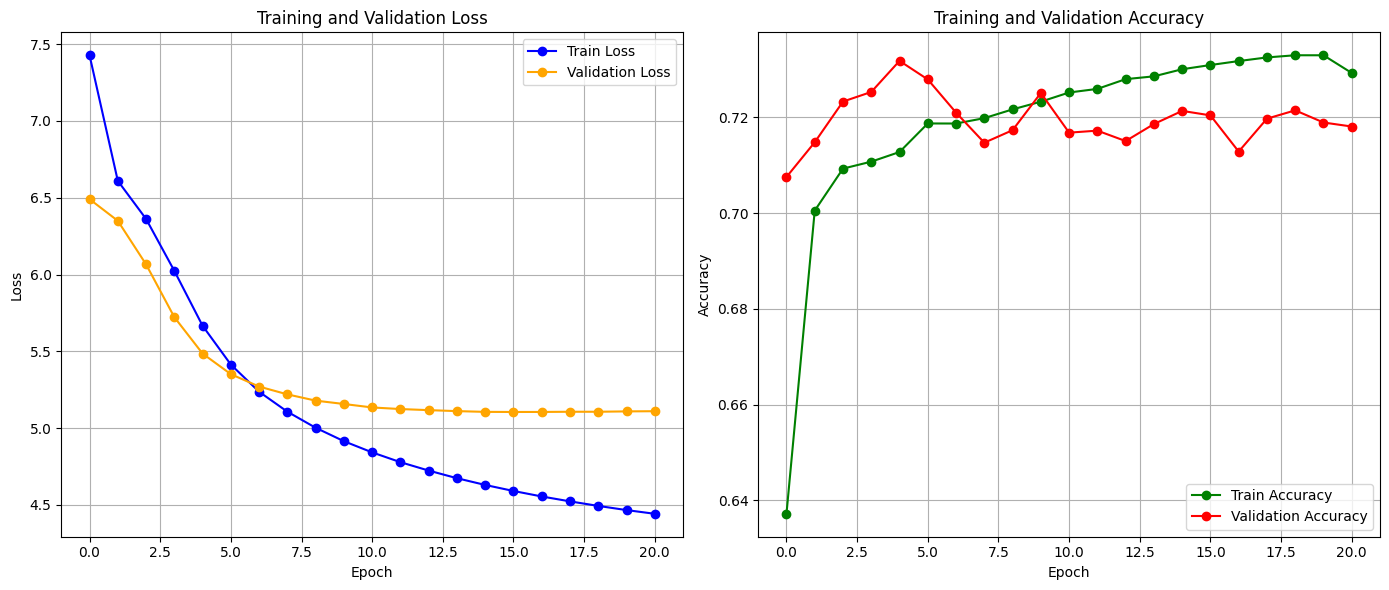

In [ ]:
#Save Model
model.save('/content/drive/MyDrive/data7901,7903/rnn_simple_3.keras')

#Visualization 
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save the entire figure
#plt.savefig("rnn_training_history.png")
plt.show()

#### Testing

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the test input and target texts
x_ts_seq = input_tok.texts_to_sequences(x_ts)
y_ts_seq = target_tok.texts_to_sequences(y_ts)

# Pad the sequences
enc_input_ts = pad_sequences(x_ts_seq, maxlen=max_input_len, padding='post')
dec_input_ts = pad_sequences(y_ts_seq, maxlen=max_target_len, padding='post')

# shifting the target sequences by one position
dec_target_ts = np.zeros_like(dec_input_ts)
dec_target_ts[:, 0:-1] = dec_input_ts[:, 1:]
dec_target_ts[:, -1] = 0

# Evaluate the model on the test data
loss, accuracy = model.evaluate([enc_input_ts, dec_input_ts], dec_target_ts, verbose=1)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7012 - loss: 5.1154
Test Loss: 5.1326
Test Accuracy: 0.7045
